## Bagging and Random Forests Implementation

In [1]:
import os
os.chdir('C:\\Users\\Bangda\\Desktop')
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Bootstrap

* Example: using bootstrap to estimate the mean and variance of a standard random normal sample

In [2]:
X = np.random.randn(100)
print("Mean:{}\nVariance:{}\n".format(np.mean(X), np.var(X)))

Mean:-0.175673121371
Variance:0.815885946342



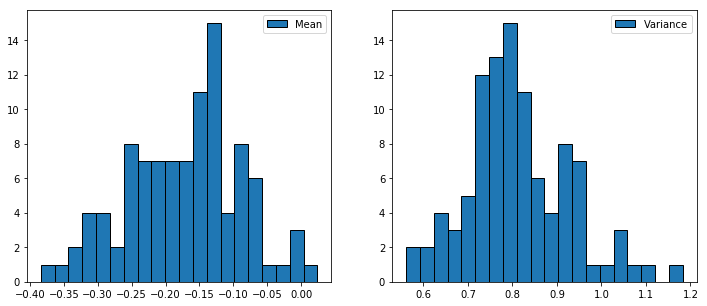

In [3]:
B = 100
bootstrap_sample = np.zeros((100, 100))
for i in xrange(B):
    sample_idx = np.random.choice(X.shape[0], size = X.shape[0], replace = True)
    bootstrap_sample[i, :] = X[sample_idx]

sample_mean = np.mean(bootstrap_sample, axis = 1)
sample_var  = np.var(bootstrap_sample, axis = 1)

mpl.rcParams['figure.figsize'] = 12, 5
plt.subplot(1, 2, 1)
plt.hist(sample_mean, bins = 20, edgeColor = 'k')
plt.legend(['Mean'])
plt.subplot(1, 2, 2)
plt.hist(sample_var, bins = 20, edgeColor = 'k')
plt.legend(['Variance'])
plt.show()

### Bagging

Here I use the decision tree from `sklearn` rather than the class I defined myself just because the self defined decision tree is still need to update and maintenance, the function is still limited. I hope that I could implement later using my own decision tree class. Also in this example I won't split the data into train and test sets, since I just focus on the comparison of single classifier algorithm and ensemble algorithm.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.base import clone
from scipy.stats import mode

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [6]:
single_clf = DecisionTreeClassifier(max_depth = 5, max_features = 4, min_samples_split = 5)
single_clf.fit(X, y)
y_pred = single_clf.predict(X)
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]])

In [7]:
class BaggingClassifier:
    def __init__(self, B = 100, n_estimator = 50, max_depth = 3, min_samples_split = 5):
        self.B = B
        self.n_estimator = n_estimator
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.all_trees = []
    
    def fit(self, X, y):
        bootstrap_sample_X = np.zeros((X.shape[0], X.shape[1], B))
        bootstrap_sample_y = np.zeros((len(y), B))
        for b in range(self.B):
            sample_idx = np.random.choice(X.shape[0], size = X.shape[0], replace = True)
            bootstrap_sample_X[:, :, b] = X[sample_idx, :]
            bootstrap_sample_y[:, b] = y[sample_idx]
            clf = DecisionTreeClassifier(max_depth = self.max_depth, max_features = X.shape[1], min_samples_split = self.min_samples_split)
            self.all_trees.append(clone(clf))
            self.all_trees[b].fit(bootstrap_sample_X[:, :, b], bootstrap_sample_y[:, b])

    def predict(self, X):
        predicts = np.zeros((X.shape[0], self.B))
        for i in range(self.B):
            predicts[:, i] = self.all_trees[i].predict(X)
        
        return mode(predicts, axis = 1)[0]

In [8]:
bg_clf = BaggingClassifier()
bg_clf.fit(X, y)
y_pred = bg_clf.predict(X)
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  1, 49]])

### Random Forests

Random forests can decorrelate the trees which makes an improvement over bagging. When building the decision trees, each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors.

#### First attempt: sample predictors for one tree rather than one split

In [9]:
class RandomForestsClassifier:
    def __init__(self, max_features, B = 100, n_estimator = 50, max_depth = 3, min_samples_split = 5):
        self.B = B
        self.n_estimator = n_estimator
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.all_trees = []
        self.max_features = max_features
        self.feature_indices = []
    
    def fit(self, X, y):
        bootstrap_sample_X = np.zeros((X.shape[0], self.max_features, B))
        bootstrap_sample_y = np.zeros((len(y), B))
        for b in range(self.B):
            feature_idx = np.random.choice(X.shape[1], size = self.max_features, replace = False)
            self.feature_indices.append(feature_idx)
            sample_idx  = np.random.choice(X.shape[0], size = X.shape[0], replace = True)
            bootstrap_sample_X[:, :, b] = X[:, feature_idx][sample_idx]
            bootstrap_sample_y[:, b] = y[sample_idx]
            clf = DecisionTreeClassifier(max_depth = self.max_depth, max_features = self.max_features, min_samples_split = self.min_samples_split)
            self.all_trees.append(clone(clf))
            self.all_trees[b].fit(bootstrap_sample_X[:, :, b], bootstrap_sample_y[:, b])

    def predict(self, X):
        predicts = np.zeros((X.shape[0], self.B))
        for i in range(self.B):
            predicts[:, i] = self.all_trees[i].predict(X[:, self.feature_indices[i]])
        
        return mode(predicts, axis = 1)[0]

In [10]:
rf_clf = RandomForestsClassifier(max_features = 2)
rf_clf.fit(X, y)
y_pred = rf_clf.predict(X)
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  2, 48]])

### Out of Bag Error

* Using LOOCV error to estimate

### Variable Importance

* Calculate the average RSS decreasing due to splits over a given feature